<a href="https://colab.research.google.com/github/murmayasa/murmayasa/blob/main/model_klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, classification_report
from sklearn.utils import shuffle
import random
import pandas as pd
import matplotlib.pyplot as plt
keras.optimizers.Adam

keras.optimizers.adam.Adam

# Mengakses Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
base_dir = '/content/drive/My Drive/SEMINAR_MURMAYASA 19101032/Projek/dataset/dataset 2'
!ls "/content/drive/My Drive/SEMINAR_MURMAYASA 19101032/Projek/dataset/dataset 2"

dataset_files = os.listdir(base_dir)
class_counts = []
class_labels = []

for class_dir in dataset_files:
    class_path = os.path.join(base_dir, class_dir)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        class_counts.append(class_count)
        class_labels.append(class_dir)

data = {'Kelas': class_labels, 'Jumlah Data': class_counts}
df = pd.DataFrame(data)
print(df)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
cataract  normal
      Kelas  Jumlah Data
0  cataract          516
1    normal          523


# Menampilkan jumlah dataset

Jumlah data setiap kelas
Jumlah dataset Cataract :  516
Jumlah dataset Normal :  523


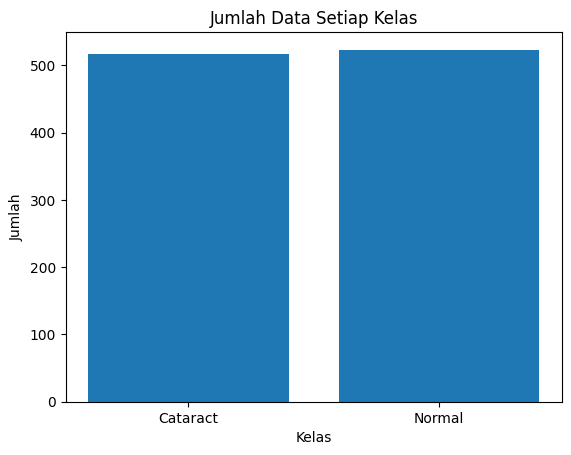

In [ ]:
cataract_dir = os.path.join(base_dir, 'cataract/')
normal_dir = os.path.join(base_dir, 'normal/')

print("Jumlah data setiap kelas")
print('Jumlah dataset Cataract : ',len(os.listdir(cataract_dir)))
print('Jumlah dataset Normal : ',len(os.listdir(normal_dir)))

num_cataract = len(os.listdir(cataract_dir))
num_normal = len(os.listdir(normal_dir))

# Menampilkan diagram jumlah
labels = ['Cataract', 'Normal']
values = [num_cataract, num_normal]

plt.bar(labels, values)
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Setiap Kelas')
plt.show()

# Menggabungkan dataset

In [ ]:
dataset_dir = os.path.join(base_dir, 'dataset')
train_dir = os.path.join(base_dir, 'latih')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validasi')

# Split Dataset

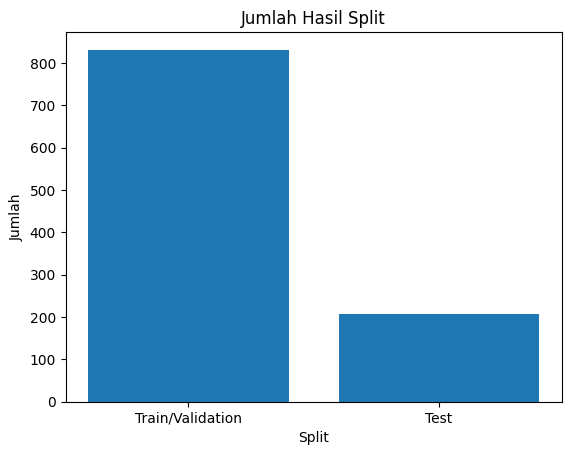

In [ ]:
image_paths = []
labels = []
for label, label_dir in enumerate([cataract_dir, normal_dir]):
    for filename in os.listdir(label_dir):
        image_paths.append(os.path.join(label_dir, filename))
        labels.append(label)

train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

num_train_val = len(train_val_paths)
num_test = len(test_paths)

# Menampilkan diagram jumlah split
labels = ['Train/Validation', 'Test']
values = [num_train_val, num_test]
plt.bar(labels, values)
plt.xlabel('Split')
plt.ylabel('Jumlah')
plt.title('Jumlah Hasil Split')
plt.show()

def my_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_Score = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1_Score))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1_Score

# Pembuatan Model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation='softmax'),
])

# Compile

In [ ]:
learning_rate = 0.001
model.compile(loss='categorical_crossentropy',
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 49, 74, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 23, 36, 64)       

# Training Model

In [ ]:
class_labels = [cataract_dir, normal_dir]
skf = StratifiedKFold(n_splits=5, shuffle=True)

fold_num = 0
test_losses = []
test_accuracies = []
confusion_matrices = []

for train_index, val_index in skf.split(train_val_paths, train_val_labels):
    fold_num += 1
    print("Results for fold:", fold_num)
    X_train, X_val = np.array(train_val_paths)[train_index], np.array(train_val_paths)[val_index]
    Y_train, Y_val = np.array(train_val_labels)[train_index], np.array(train_val_labels)[val_index]

    Y_train = Y_train.astype(str)
    Y_val = Y_val.astype(str)

    for each_index in range(len(X_val)):
        class_label = ''
        for i in range(len(class_labels)):
            if Y_val[each_index] == str(i):
                class_label = class_labels[i]
        shutil.move(
            os.path.join(base_dir, 'latih', class_label, X_val[each_index]),
            os.path.join(base_dir, 'validasi', class_label, X_val[each_index])
        )

    train_datagen = ImageDataGenerator(
        rescale=1./225,
        brightness_range=[0.5, 1.0],
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        rotation_range=45,
        fill_mode='mirror',
    )

    train_generator = train_datagen.flow_from_dataframe(
        pd.DataFrame({"image_path": X_train, "label": Y_train}),
        x_col="image_path",
        y_col="label",
        target_size=(100, 150),
        batch_size=32,
        class_mode="categorical",
        shuffle=True
    )

    val_datagen = ImageDataGenerator(rescale=1./225)

    val_generator = val_datagen.flow_from_dataframe(
        pd.DataFrame({"image_path": X_val, "label": Y_val}),
        x_col="image_path",
        y_col="label",
        target_size=(100, 150),
        batch_size=32,
        class_mode="categorical",
        shuffle=False
    )

    # Training Model
    history = model.fit(
        train_generator,
        epochs=25,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        verbose=2
    )

    predictions = model.predict(val_generator, verbose=1)
    y_predictions = np.argmax(predictions, axis=1)
    true_classes = val_generator.classes

    # evaluate validation performance
    print("*** Performance on Validation data ***")
    val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)

Results for fold: 1
Found 664 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
Epoch 1/25
21/21 - 36s - loss: 0.8873 - accuracy: 0.5075 - val_loss: 0.6923 - val_accuracy: 0.5030 - 36s/epoch - 2s/step
Epoch 2/25
21/21 - 25s - loss: 0.6893 - accuracy: 0.5512 - val_loss: 0.6929 - val_accuracy: 0.5030 - 25s/epoch - 1s/step
Epoch 3/25
21/21 - 24s - loss: 0.6953 - accuracy: 0.5030 - val_loss: 0.6933 - val_accuracy: 0.5030 - 24s/epoch - 1s/step
Epoch 4/25
21/21 - 22s - loss: 0.6925 - accuracy: 0.5301 - val_loss: 0.6924 - val_accuracy: 0.5030 - 22s/epoch - 1s/step
Epoch 5/25
21/21 - 24s - loss: 0.6850 - accuracy: 0.6160 - val_loss: 0.6658 - val_accuracy: 0.6527 - 24s/epoch - 1s/step
Epoch 6/25
21/21 - 22s - loss: 0.6578 - accuracy: 0.6431 - val_loss: 0.6483 - val_accuracy: 0.6647 - 22s/epoch - 1s/step
Epoch 7/25
21/21 - 24s - loss: 0.6503 - accuracy: 0.6205 - val_loss: 0.5883 - val_accuracy: 0.7605 - 24s/epoch - 1s/step
Epoch 8/25
21

# Report Hasil Training

In [ ]:
print("*** Classification Report ***")
clr = classification_report(true_classes, y_predictions, target_names=['cataract', 'normal'])
print(clr)

*** Classification Report ***
              precision    recall  f1-score   support

    cataract       1.00      0.24      0.39        82
      normal       0.58      1.00      0.73        84

    accuracy                           0.63       166
   macro avg       0.79      0.62      0.56       166
weighted avg       0.79      0.63      0.56       166



#Testing Model

In [ ]:
class_labels = [cataract_dir, normal_dir]
skf = StratifiedKFold(n_splits=5, shuffle=True)

fold_num = 0
test_losses = []
test_accuracies = []
confusion_matrices = []

for train_index, test_index in skf.split(train_val_paths, train_val_labels):
    fold_num += 1
    print("Results for fold : ", fold_num)
    X_train, X_test = np.array(train_val_paths)[train_index], np.array(train_val_paths)[test_index]
    Y_train, Y_test = np.array(train_val_labels)[train_index], np.array(train_val_labels)[test_index]

    for each_index in range(len(X_test)):
        class_label = ''
        for i in range(len(class_labels)):
            if Y_test[each_index] == str(i):
                class_label = class_labels[i]
        shutil.move(
            os.path.join(base_dir, 'latih', class_label, X_test[each_index]),
            os.path.join(base_dir, 'test', class_label, X_test[each_index])
        )

    test_datagen = ImageDataGenerator(rescale=1./225)
    test_labels = [str(label) for label in Y_test]

    test_generator = test_datagen.flow_from_dataframe(
        pd.DataFrame({'image_path': X_test, 'label': test_labels}),
        x_col='image_path',
        y_col='label',
        target_size=(100, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    test_loss, test_acc = model.evaluate(
        test_generator,
        steps=len(test_generator),
        verbose=1
    )

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    predictions = model.predict(test_generator, verbose=1)
    y_predictions = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # evaluate validation performance
    print("*** Performance on Validation data ***")
    val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)
    confusion_matrices.append(confusion_matrix(true_classes, y_predictions))

Results for fold :  1
Found 167 validated image filenames belonging to 2 classes.
6/6 [==============================] - 4s 604ms/step
*** Performance on Validation data ***
Accuracy  : 0.7724550898203593
Precision : 0.7725788732612294
f1Score : 0.7724061203274942
[[63 20]
 [18 66]]
Results for fold :  2
Found 166 validated image filenames belonging to 2 classes.
6/6 [==============================] - 4s 600ms/step
*** Performance on Validation data ***
Accuracy  : 0.7228915662650602
Precision : 0.7234104466753964
f1Score : 0.7227305737109658
[[58 25]
 [21 62]]
Results for fold :  3
Found 166 validated image filenames belonging to 2 classes.
6/6 [==============================] - 5s 850ms/step
*** Performance on Validation data ***
Accuracy  : 0.8433734939759037
Precision : 0.8433734939759037
f1Score : 0.8433734939759037
[[70 13]
 [13 70]]
Results for fold :  4
Found 166 validated image filenames belonging to 2 classes.
6/6 [==============================] - 4s 589ms/step
*** Performan

# Report Hasil Testing

In [ ]:
print("*** Classification Report ***")
clr = classification_report(true_classes, y_predictions, target_names=['cataract', 'normal'])
print(clr)

*** Classification Report ***
              precision    recall  f1-score   support

    cataract       1.00      0.16      0.27        82
      normal       0.55      1.00      0.71        84

    accuracy                           0.58       166
   macro avg       0.77      0.58      0.49       166
weighted avg       0.77      0.58      0.49       166

